In [3]:
from theano.sandbox import cuda

In [4]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [5]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [8]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [9]:
print (pd.read_csv(path+'movies.csv').set_index('movieId'))

                                                     title  \
movieId                                                      
1                                         Toy Story (1995)   
2                                           Jumanji (1995)   
3                                  Grumpier Old Men (1995)   
4                                 Waiting to Exhale (1995)   
5                       Father of the Bride Part II (1995)   
6                                              Heat (1995)   
7                                           Sabrina (1995)   
8                                      Tom and Huck (1995)   
9                                      Sudden Death (1995)   
10                                        GoldenEye (1995)   
11                          American President, The (1995)   
12                      Dracula: Dead and Loving It (1995)   
13                                            Balto (1995)   
14                                            Nixon (1995)   
15      

In [10]:
print (movie_names)

{1L: 'Toy Story (1995)', 2L: 'Jumanji (1995)', 3L: 'Grumpier Old Men (1995)', 4L: 'Waiting to Exhale (1995)', 5L: 'Father of the Bride Part II (1995)', 6L: 'Heat (1995)', 7L: 'Sabrina (1995)', 8L: 'Tom and Huck (1995)', 9L: 'Sudden Death (1995)', 10L: 'GoldenEye (1995)', 11L: 'American President, The (1995)', 12L: 'Dracula: Dead and Loving It (1995)', 13L: 'Balto (1995)', 14L: 'Nixon (1995)', 15L: 'Cutthroat Island (1995)', 16L: 'Casino (1995)', 17L: 'Sense and Sensibility (1995)', 18L: 'Four Rooms (1995)', 19L: 'Ace Ventura: When Nature Calls (1995)', 20L: 'Money Train (1995)', 21L: 'Get Shorty (1995)', 22L: 'Copycat (1995)', 23L: 'Assassins (1995)', 24L: 'Powder (1995)', 25L: 'Leaving Las Vegas (1995)', 26L: 'Othello (1995)', 27L: 'Now and Then (1995)', 28L: 'Persuasion (1995)', 29L: 'City of Lost Children, The (Cit\xc3\xa9 des enfants perdus, La) (1995)', 30L: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 31L: 'Dangerous Minds (1995)', 32L: 'Twelve Monkeys (a.k.a. 12 Monke

In [14]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [15]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [16]:
print (userid2idx)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [17]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [18]:
print (ratings.userId)

0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          1
21          1
22          1
23          1
24          1
25          1
26          1
27          1
28          1
29          1
         ... 
99974     670
99975     670
99976     670
99977     670
99978     670
99979     670
99980     670
99981     670
99982     670
99983     670
99984     670
99985     670
99986     670
99987     670
99988     670
99989     670
99990     670
99991     670
99992     670
99993     670
99994     670
99995     670
99996     670
99997     670
99998     670
99999     670
100000    670
100001    670
100002    670
100003    670
Name: userId, Length: 100004, dtype: int64


In [19]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [20]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [21]:
n_factors = 50

In [22]:
np.random.seed = 42

Randomly split into training and validation.

In [23]:
msk = np.random.rand(len(ratings)) < 0.8
print (msk)
trn = ratings[msk]
val = ratings[~msk]

[ True  True  True ...  True  True  True]


In [24]:
print (trn)

        userId  movieId  rating   timestamp
0            0        0     2.5  1260759144
1            0        1     3.0  1260759179
2            0        2     3.0  1260759182
4            0        4     4.0  1260759205
7            0        7     2.0  1260759148
8            0        8     3.5  1260759125
9            0        9     2.0  1260759131
10           0       10     2.5  1260759135
11           0       11     1.0  1260759203
12           0       12     4.0  1260759191
13           0       13     4.0  1260759139
14           0       14     3.0  1260759194
15           0       15     2.0  1260759198
16           0       16     2.0  1260759108
17           0       17     2.5  1260759113
18           0       18     1.0  1260759200
19           0       19     3.0  1260759117
20           1       20     4.0   835355493
21           1       21     5.0   835355681
22           1       22     5.0   835355604
25           1       25     3.0   835356031
26           1       26     3.0 

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [25]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [26]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [27]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [28]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [29]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [30]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [31]:
print (u)

Reshape{3}.0


In [32]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [36]:
x

Reshape{2}.0

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79972 samples, validate on 20032 samples
Epoch 1/1
79972/79972 [==============================] - 15s - loss: 2.4013 - val_loss: 2.5880


In [26]:
model.optimizer.lr=0.01

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80012 samples, validate on 19992 samples
Epoch 1/3
80012/80012 [==============================] - 15s - loss: 2.4265 - val_loss: 2.5907
Epoch 2/3
80012/80012 [==============================] - 16s - loss: 2.2678 - val_loss: 2.5534
Epoch 3/3
80012/80012 [==============================] - 15s - loss: 2.2119 - val_loss: 2.5437


In [54]:
model.optimizer.lr=0.001

In [55]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80043 samples, validate on 19961 samples
Epoch 1/6
80043/80043 [==============================] - 15s - loss: 2.1381 - val_loss: 2.5182
Epoch 2/6
80043/80043 [==============================] - 16s - loss: 2.1084 - val_loss: 2.5301
Epoch 3/6
80043/80043 [==============================] - 16s - loss: 2.0873 - val_loss: 2.5324
Epoch 4/6
80043/80043 [==============================] - 16s - loss: 2.0652 - val_loss: 2.5346s: 2.0
Epoch 5/6
80043/80043 [==============================] - 16s - loss: 2.0465 - val_loss: 2.5448
Epoch 6/6
80043/80043 [==============================] - 16s - loss: 2.0273 - val_loss: 2.5484s: 2.0 - ETA: 0s


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [38]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [39]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [40]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [41]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [42]:
print (ub)

Reshape{2}.0


In [43]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [44]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79972 samples, validate on 20032 samples
Epoch 1/1
79972/79972 [==============================] - 17s - loss: 8.7172 - val_loss: 3.5004


In [45]:
model.optimizer.lr=0.01

In [46]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79972 samples, validate on 20032 samples
Epoch 1/6
26752/79972 [=========>....................] - ETA: 12s - loss: 2.9069

KeyboardInterrupt: 

In [49]:
model.optimizer.lr=0.001

In [50]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79972 samples, validate on 20032 samples
Epoch 1/10
79972/79972 [==============================] - 19s - loss: 1.5582 - val_loss: 1.7787
Epoch 2/10
79972/79972 [==============================] - 19s - loss: 1.4877 - val_loss: 1.7148
Epoch 3/10
79972/79972 [==============================] - 18s - loss: 1.4199 - val_loss: 1.6640
Epoch 4/10
79972/79972 [==============================] - 20s - loss: 1.3540 - val_loss: 1.6039
Epoch 5/10
79972/79972 [==============================] - 18s - loss: 1.2890 - val_loss: 1.5507
Epoch 6/10
79972/79972 [==============================] - 19s - loss: 1.2274 - val_loss: 1.4990
Epoch 7/10
79972/79972 [==============================] - 17s - loss: 1.1666 - val_loss: 1.4484
Epoch 8/10
79972/79972 [==============================] - 18s - loss: 1.1089 - val_loss: 1.4050
Epoch 9/10
79972/79972 [==============================] - 16s - loss: 1.0537 - val_loss: 1.3623
Epoch 10/10
79972/79972 [==============================] - 10s - loss: 1.0016 - val_lo

In [48]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79972 samples, validate on 20032 samples
Epoch 1/5
79972/79972 [==============================] - 20s - loss: 2.2864 - val_loss: 2.2066
Epoch 2/5
79972/79972 [==============================] - 21s - loss: 1.9308 - val_loss: 2.0624
Epoch 3/5
79972/79972 [==============================] - 18s - loss: 1.7994 - val_loss: 1.9797
Epoch 4/5
79972/79972 [==============================] - 20s - loss: 1.7086 - val_loss: 1.9107
Epoch 5/5
79972/79972 [==============================] - 19s - loss: 1.6302 - val_loss: 1.8428


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [69]:
model.save_weights(model_path+'bias.h5')

In [70]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [51]:
model.predict([np.array([1]), np.array([31])])

array([[3.7773]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [44]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
print (g)

movieId
0        42
1        42
2        33
3        48
4        46
5        48
6        46
7        46
8        52
9        39
10       47
11       46
12       46
13       47
14       36
15       42
16       53
17       47
18       43
19       62
20      122
21       86
22      120
23      201
24      201
25       51
26       87
27      228
28       26
29      200
       ... 
9036      1
9037      1
9038      1
9039      1
9040      1
9041      1
9042      1
9043      1
9044      1
9045      1
9046      1
9047      1
9048      1
9049      1
9050      1
9051      1
9052      1
9053      1
9054      1
9055      1
9056      1
9057      1
9058      1
9059      1
9060      1
9061      1
9062      1
9063      1
9064      1
9065      1
Name: rating, Length: 9066, dtype: int64


In [46]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [47]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.006016493, 'Children of the Corn (1984)'),
 (0.0026129761, '8MM (1999)'),
 (0.012310052, 'Vampire in Brooklyn (1995)'),
 (0.020500937, 'Exotica (1994)'),
 (0.021057202, 'Little Nicky (2000)'),
 (0.021194119, 'Cabin in the Woods, The (2012)'),
 (0.021726277, 'Hulk (2003)'),
 (0.022879807, 'Hangover Part II, The (2011)'),
 (0.024350593, 'Rashomon (Rash\xc3\xb4mon) (1950)'),
 (0.02435485, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.02659211, "Buffalo '66 (a.k.a. Buffalo 66) (1998)"),
 (0.02840541, 'How to Make an American Quilt (1995)'),
 (0.028881174, 'Snow Falling on Cedars (1999)'),
 (0.029082762, 'Blades of Glory (2007)'),
 (0.029312484, 'Stepford Wives, The (1975)')]

In [44]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4472733, 'Cyrano de Bergerac (1990)'),
 (1.3778598, 'Sweet and Lowdown (1999)'),
 (1.3424659, 'Shawshank Redemption, The (1994)'),
 (1.3202431, 'Argo (2012)'),
 (1.3075899, 'Ray (2004)'),
 (1.2925439, 'Rush (2013)'),
 (1.2901822,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.2837858, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2804954, 'Last King of Scotland, The (2006)'),
 (1.2796255, 'You Can Count on Me (2000)'),
 (1.2788166, 'Moon (2009)'),
 (1.2776535, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2759542, 'Tom Jones (1963)'),
 (1.2714852, 'Grave of the Fireflies (Hotaru no haka) (1988)'),
 (1.2556783, 'About Time (2013)')]

We can now do the same thing for the embeddings.

In [45]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000L, 50L)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [47]:
fac0 = movie_pca[0]

In [48]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.05387686, 'American Beauty (1999)'),
 (0.052163094, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.050115306, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.049794577, 'Usual Suspects, The (1995)'),
 (0.04936441, 'Godfather, The (1972)'),
 (0.049327616, "Schindler's List (1993)"),
 (0.049067076, 'Fight Club (1999)'),
 (0.04900614, 'Shawshank Redemption, The (1994)'),
 (0.048724037, 'Minority Report (2002)'),
 (0.04868563, 'Toy Story (1995)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.014891516, 'Anaconda (1997)'),
 (-0.010730254, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.009392654, 'Battlefield Earth (2000)'),
 (-0.0089397095, 'Police Academy 3: Back in Training (1986)'),
 (-0.007382697, 'Blade: Trinity (2004)'),
 (-0.007092133, 'Stepford Wives, The (1975)'),
 (-0.0067860056,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (-0.0066246074, 'Fantastic Four (2005)'),
 (-0.00658044, 'Children of the Corn (1984)'),
 (-0.0059754695, 'Howard the Duck (1986)')]

In [51]:
fac1 = movie_pca[1]

In [52]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06866304, 'Clockwork Orange, A (1971)'),
 (0.060323667, 'Brokeback Mountain (2005)'),
 (0.055436682, 'Apocalypse Now (1979)'),
 (0.055253427, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.053365394, 'Chinatown (1974)'),
 (0.052399382, 'Big Lebowski, The (1998)'),
 (0.05183134, '2001: A Space Odyssey (1968)'),
 (0.049333744, 'Vertigo (1958)'),
 (0.048927948, 'Taxi Driver (1976)'),
 (0.04854362,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094923824, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.07899682, 'Armageddon (1998)'),
 (-0.076833405, 'Stargate (1994)'),
 (-0.075506866, 'Speed (1994)'),
 (-0.075318225, 'Cliffhanger (1993)'),
 (-0.07036733, 'Mission: Impossible (1996)'),
 (-0.06830898, 'Titanic (1997)'),
 (-0.067632176, 'Rock, The (1996)'),
 (-0.06747497, 'Firm, The (1993)'),
 (-0.067181, 'Casper (1995)')]

In [55]:
fac2 = movie_pca[2]

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.0729532, 'Army of Darkness (1993)'),
 (0.07279517, 'Dogma (1999)'),
 (0.0682764, 'Game, The (1997)'),
 (0.06776607, 'Sin City (2005)'),
 (0.06751683, 'Dirty Rotten Scoundrels (1988)'),
 (0.06689296, 'American Psycho (2000)'),
 (0.06625218, 'Fear and Loathing in Las Vegas (1998)'),
 (0.06553017, 'Happy Gilmore (1996)'),
 (0.06542622, 'Kill Bill: Vol. 1 (2003)'),
 (0.06485254, 'Kill Bill: Vol. 2 (2004)')]

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1101904, 'Babe (1995)'),
 (-0.09419307, "Schindler's List (1993)"),
 (-0.09244842, 'Beauty and the Beast (1991)'),
 (-0.07692745, 'Mrs. Doubtfire (1993)'),
 (-0.07463532, 'Lion King, The (1994)'),
 (-0.07430122, 'Hunchback of Notre Dame, The (1996)'),
 (-0.07097623, 'While You Were Sleeping (1995)'),
 (-0.067378156, 'Dances with Wolves (1990)'),
 (-0.0667212, 'Titanic (1997)'),
 (-0.06638915, 'Apollo 13 (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [59]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

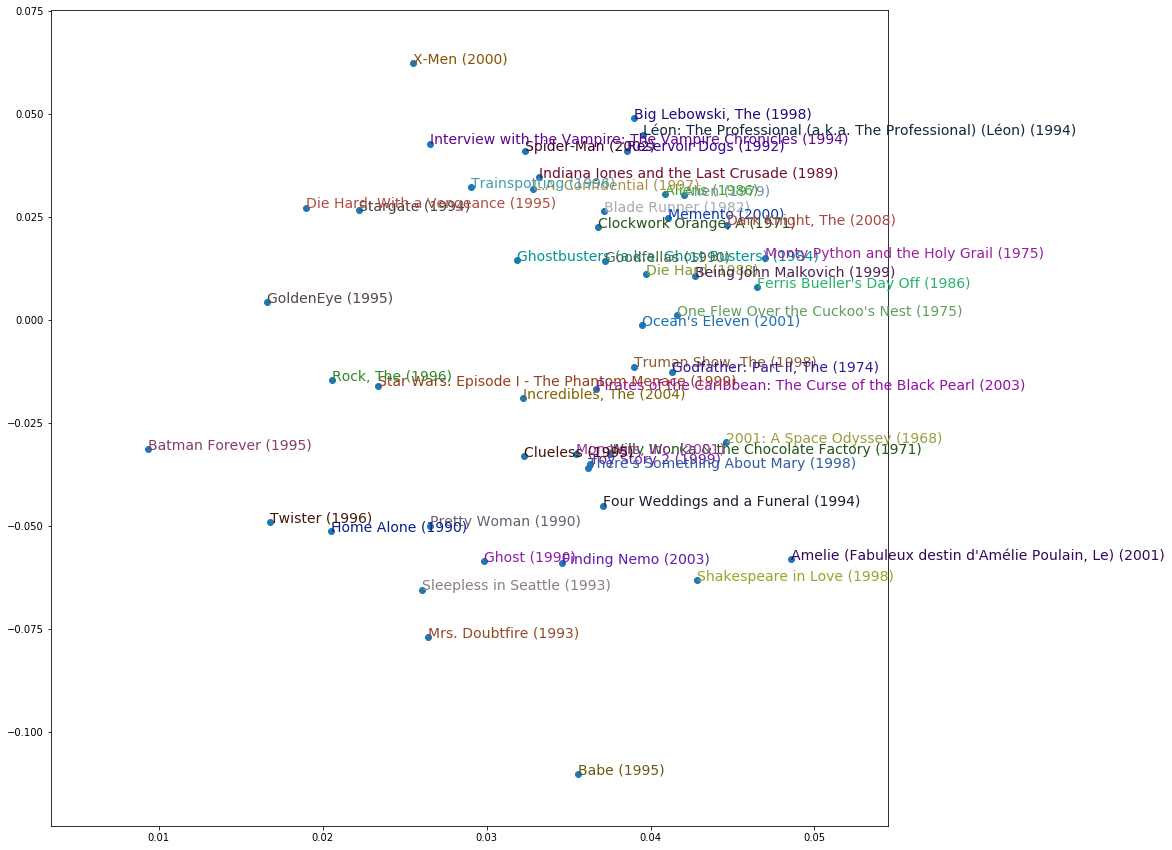

In [60]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [89]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [90]:

print (user_in)

user_in


In [91]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [55]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80012 samples, validate on 19992 samples
Epoch 1/8
80012/80012 [==============================] - 22s - loss: 2.5968 - val_loss: 0.9346
Epoch 2/8
80012/80012 [==============================] - 22s - loss: 1.5581 - val_loss: 0.8828
Epoch 3/8
80012/80012 [==============================] - 22s - loss: 1.2300 - val_loss: 0.8575
Epoch 4/8
42176/80012 [==============>...............] - ETA: 10s - loss: 1.0455

KeyboardInterrupt: 

This improves on our already impressive accuracy even further!